# Analyzing Solar Spectroscopy

## DACE - python APIs

## Authors
Xavier? (University of Geneva)

Nicolas Unger (DACE Data Scientist)

##  Goals
1. Query the Sun spectroscopy database and plot the data
2. Download raw files from the spectrograph

## Topics
1. Get solar timeseries by using `Sun.get_timeseries`
2. Download and look at an S2D spectrum by using `Sun.download` and the `astropy.io.fits` package

## Keywords
`Sun.get_timeseries`, `Sun.download`, `astropy.io.fits`

## Requirements
Anaconda 3, Python 3.8 or later, IPython 7.8.0<br>
**dace-query 1.1.0 or later**

## Summary
This notebook will show how to use the Sun module of the DACE API, plot the data and download raw files from the spectrograph

## Setup

Import DACE API for solar data and other useful libraries

In [1]:
from dace_query.sun import Sun
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
import os
import numpy as np

2024-04-15 09:52:15,665 - WARNING - File .dacerc not found. You are requesting data in public mode. To change this behaviour, create a .dacerc file in your home directory and fill it with your API key. More infos on https://dace.unige.ch


## Looking at the solar radial velocities (RVs)

Get solar timeseries using DACE API

In [2]:
data_original = Sun.get_timeseries(output_format="pandas")

# Show the different timeseries available
data_original.columns.to_list()

['filename',
 'instrument',
 'date_bjd',
 'rv',
 'rhk',
 'rv_diff_extinction',
 'sn_order_50',
 'airmass',
 'contrast',
 'drs_quality',
 'sn_order_40',
 'bis_span_err',
 'smw',
 'obs_quality',
 'smw_err',
 'rv_err',
 'sn_order_20',
 'fwhm',
 'coordinates',
 'contrast_raw',
 'rhk_err',
 'bis_span',
 'contrast_err',
 'sn_order_60',
 'rv_raw',
 'berv',
 'sn_order_10',
 'berv_bary_to_helio',
 'fwhm_raw',
 'fwhm_err',
 'sn_order_30',
 'texp',
 'date_night',
 'prog_id',
 'public']

In [3]:
# Remove some outliers that are more than 100 m/s away from the median
to_keep = np.abs(data_original.rv - np.median(data_original.rv)) < 100
data = data_original[to_keep]

Plot the RVs as a function of time

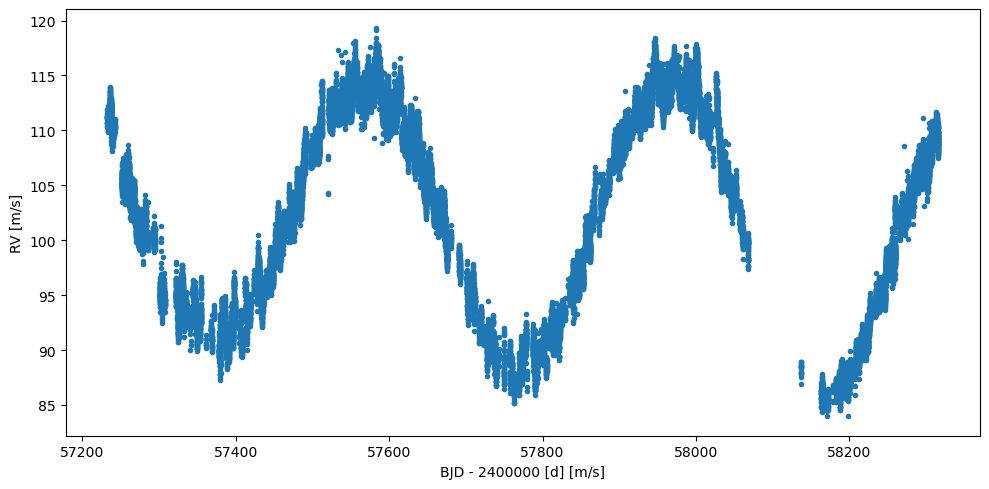

In [4]:
# Plot the raw radial velocities, in the Solar System barycenter rest frame
plt.figure(figsize=(10, 5))
plt.plot(data.date_bjd, data.rv_raw, ".")
plt.xlabel("BJD - 2400000 [d] [m/s]")
plt.ylabel("RV [m/s]")
plt.tight_layout()

Tranform the raw RVs in the heliocentric rest frame, and correct for differential extinction. As we can see, the result is the same as the `data.rv` timeseries.

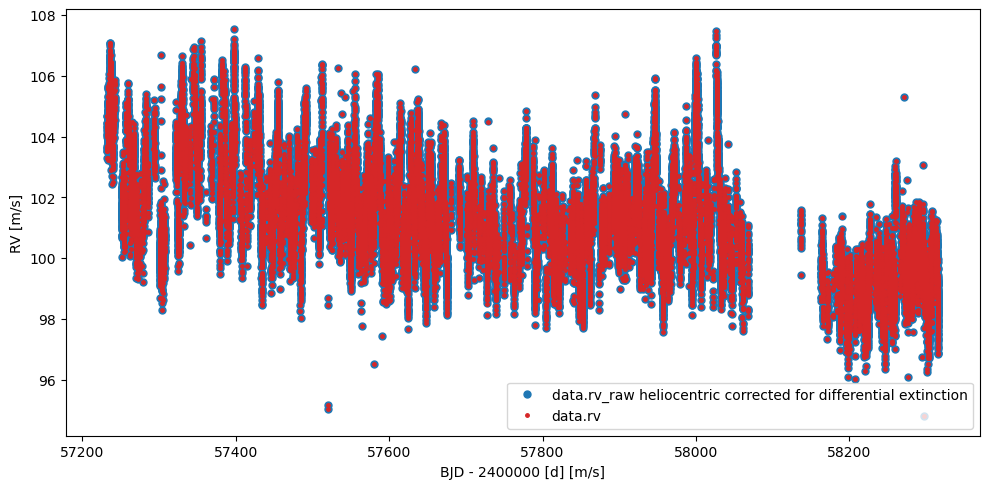

In [5]:
rv_corr = data.rv_raw - data.berv_bary_to_helio - data.rv_diff_extinction

plt.figure(figsize=(10, 5))
plt.plot(
    data.date_bjd,
    rv_corr,
    marker=".",
    ls="",
    ms=10,
    color="C0",
    label="data.rv_raw heliocentric corrected for differential extinction",
)
plt.plot(data.date_bjd, data.rv, marker=".", ls="", ms=5, color="C3", label="data.rv")
plt.legend()
plt.xlabel("BJD - 2400000 [d] [m/s]")
plt.ylabel("RV [m/s]")
plt.tight_layout()

Looking at the correlation between the RVs and the log(R'$_{HK}$) calcium activity index

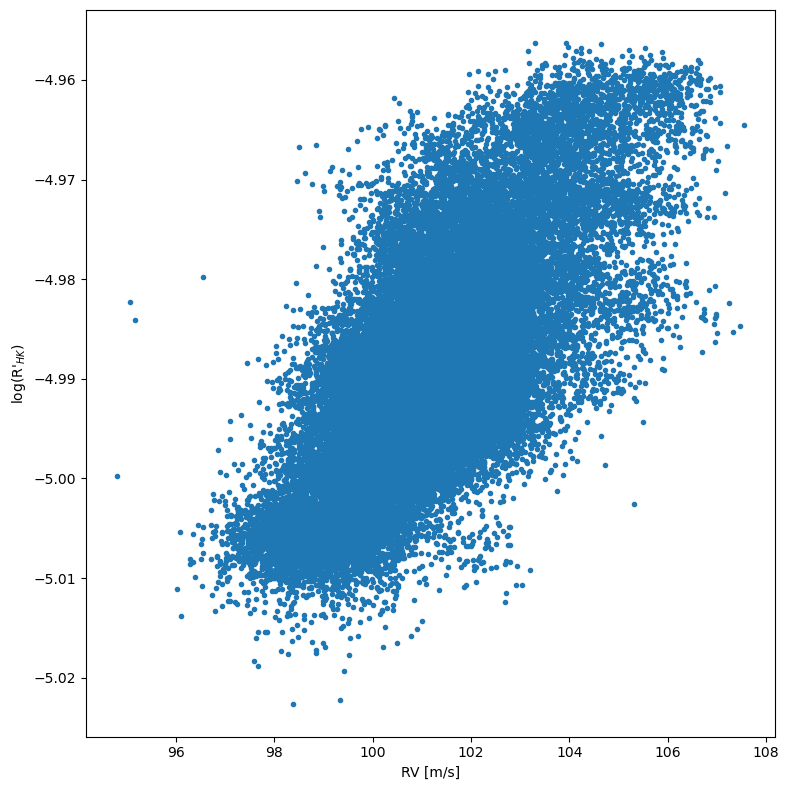

In [6]:
plt.figure(figsize=(8, 8))
plt.plot(data.rv, data.rhk, ".")
plt.xlabel("RV [m/s]")
plt.ylabel(r"log(R'$_{HK}$)")
plt.tight_layout()

## Looking at a S2D spectrum

Download one S2D spectrum locally on your computer and untar the file

In [7]:
file_rootpath = "r.HARPN.2018-06-08T13-20-27.252.fits"

In [10]:
Sun.download(
    "s2d",
    filters={"date_night": {"contains": ["2018-05"]}},
    output_directory="/solar_DACE",
    output_filename="sun_spectroscopy_data_s2d.tar.gz",
)
os.system("tar -xvf /solar_DACE/sun_spectroscopy_data_s2d.tar.gz")

2024-04-15 10:32:42,200 - ERROR - No data found.
tar: /solar_DACE/sun_spectroscopy_data_s2d.tar.gz: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now


512

In [8]:
Sun.download(
    "s2d",
    filters={"file_rootpath": {"contains": [file_rootpath]}},
    output_directory="/tmp",
    output_filename="sun_spectroscopy_data_s2d.tar.gz",
)
os.system("tar -xvf /tmp/sun_spectroscopy_data_s2d.tar.gz")

2023-11-28 10:46:29,465 - INFO - Downloading file on location : /tmp/sun_spectroscopy_data_s2d.tar.gz


 Download : 15 MB

2023-11-28 10:46:30,857 - INFO - File downloaded on location : /tmp/sun_spectroscopy_data_s2d.tar.gz


 Download : 18 MB
Download done
2018-06-08/r.HARPN.2018-06-08T13-20-27.252_S2D_A.fits
2018-06-08/r.HARPN.2018-06-08T13-20-27.252_S2D_BLAZE_A.fits


0

In [9]:
filename = "2018-06-08/r.HARPN.2018-06-08T13-20-27.252_S2D_A.fits"
# flux corrected from blaze
flux_s2d = fits.getdata(filename, 1)
# flux error corrected from blaze
flux_err_s2d = fits.getdata(filename, 2)
# wavelength solution in the air
wave_s2d = fits.getdata(filename, 5)
# Size of a pixel in wavelength, in the air
pixel_size_s2d = fits.getdata(filename, 7)

Plotting order 50 of the spectrograph

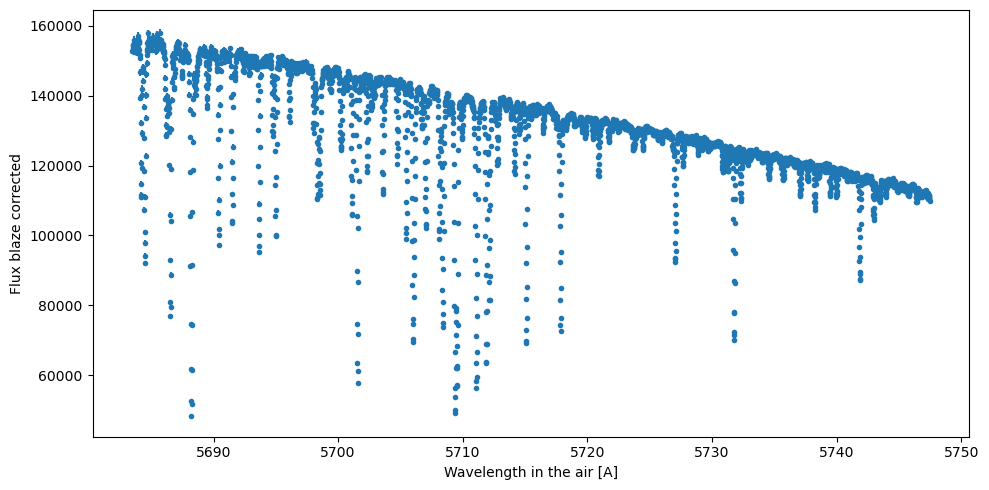

In [10]:
order = 50
plt.figure(figsize=(10, 5))
plt.errorbar(wave_s2d[order], flux_s2d[order], flux_err_s2d[order], marker=".", ls="")
plt.xlabel("Wavelength in the air [A]")
plt.ylabel("Flux blaze corrected")
plt.tight_layout()

As we can see, the continuum is not flat, due to dispersion. We can correct that by dividing the flux by the pixel size 

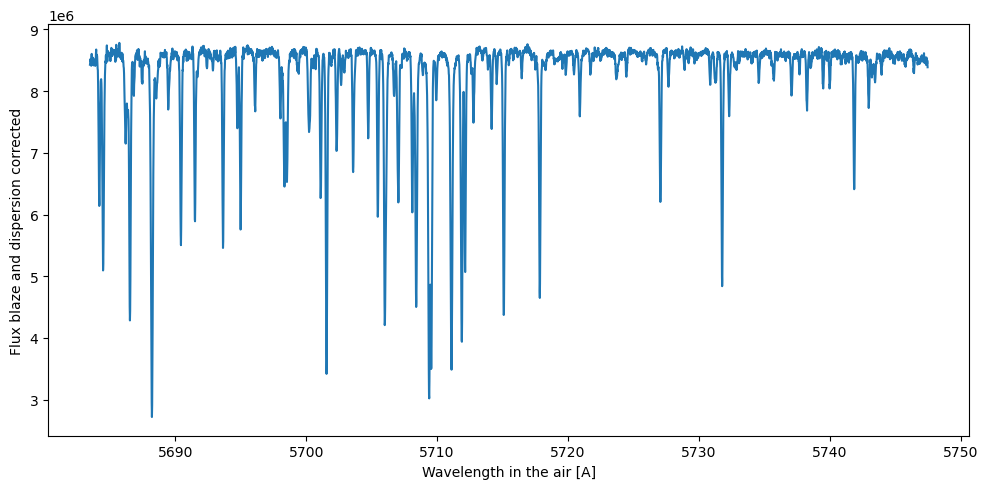

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(wave_s2d[order], flux_s2d[order] / pixel_size_s2d[order])
plt.xlabel("Wavelength in the air [A]")
plt.ylabel("Flux blaze and dispersion corrected")
plt.tight_layout()

## Looking at a S1D spectrum


Download one S1D spectrum locally on your computer and untar the file

In [12]:
Sun.download(
    "s1d",
    filters={"file_rootpath": {"contains": [file_rootpath]}},
    output_directory="/tmp",
    output_filename="sun_spectroscopy_data_s1d.tar.gz",
)
os.system("tar -xvf /tmp/sun_spectroscopy_data_s1d.tar.gz")

2023-11-28 10:46:36,607 - INFO - Downloading file on location : /tmp/sun_spectroscopy_data_s1d.tar.gz
2023-11-28 10:46:36,755 - INFO - File downloaded on location : /tmp/sun_spectroscopy_data_s1d.tar.gz


 Download : 5 MB
Download done
2018-06-08/r.HARPN.2018-06-08T13-20-27.252_S1D_A.fits


0

In [13]:
s1d = fits.getdata("2018-06-08/r.HARPN.2018-06-08T13-20-27.252_S1D_A.fits", 1)
s1d.columns

ColDefs(
    name = 'wavelength'; format = '1D'; unit = 'angstrom'
    name = 'wavelength_air'; format = '1D'; unit = 'angstrom'
    name = 'flux'; format = '1D'; unit = 'e-'
    name = 'error'; format = '1D'; unit = 'e-'
    name = 'quality'; format = '1J'
)

Plotting the S1D spectrum

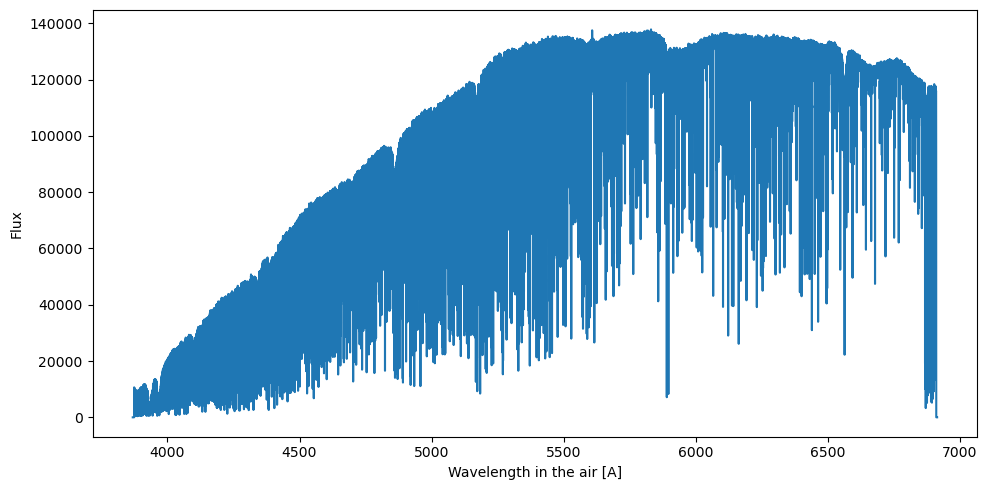

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(s1d["wavelength_air"], s1d["flux"])
plt.xlabel("Wavelength in the air [A]")
plt.ylabel("Flux")
plt.tight_layout()

## Looking at a CCF file



Download one CCF locally on your computer and untar the file

In [15]:
Sun.download(
    "ccf",
    filters={"file_rootpath": {"contains": [file_rootpath]}},
    output_directory="/tmp",
    output_filename="sun_spectroscopy_data_ccf.tar.gz",
)
os.system("tar -xvf /tmp/sun_spectroscopy_data_ccf.tar.gz")

2023-11-28 10:46:39,309 - INFO - Downloading file on location : /tmp/sun_spectroscopy_data_ccf.tar.gz
2023-11-28 10:46:39,318 - INFO - File downloaded on location : /tmp/sun_spectroscopy_data_ccf.tar.gz



Download done
2018-06-08/r.HARPN.2018-06-08T13-20-27.252_CCF_A.fits


0

In [16]:
ccf_header = fits.getheader("2018-06-08/r.HARPN.2018-06-08T13-20-27.252_CCF_A.fits")
ccf = fits.getdata("2018-06-08/r.HARPN.2018-06-08T13-20-27.252_CCF_A.fits", 1)

Plotting the CCF for order 50 and the CCF averaged over all the orders

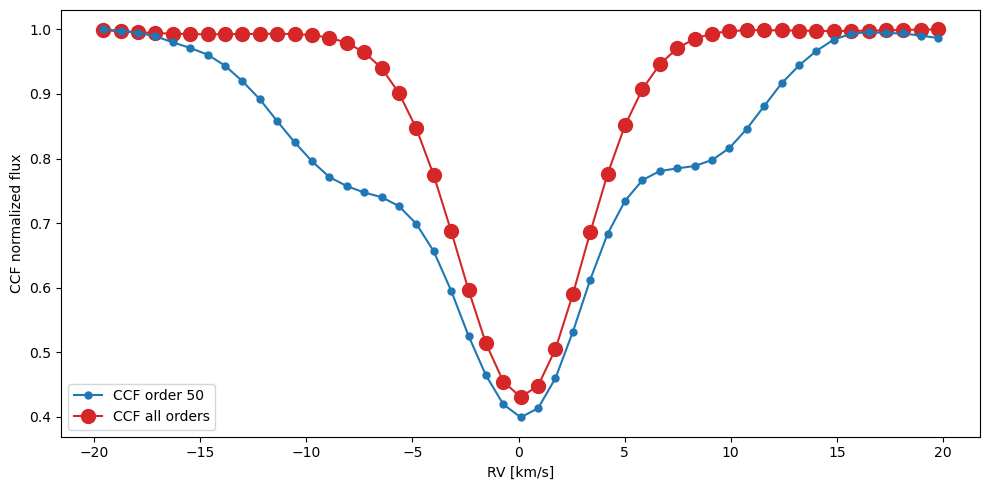

In [17]:
order = 50
plt.figure(figsize=(10, 5))
CCF_rv = np.arange(
    ccf_header["TNG RV START"],
    ccf_header["TNG RV START"] + len(ccf[0]) * ccf_header["TNG RV STEP"],
    ccf_header["TNG RV STEP"],
)
# plot the CCF of a specific order
plt.plot(
    CCF_rv,
    ccf[order] / max(ccf[order]),
    zorder=1,
    marker="o",
    ms=5,
    color="C0",
    label="CCF order %i" % (order),
)
# plot the averaged ccf of all orders
plt.plot(
    CCF_rv,
    ccf[-1] / max(ccf[-1]),
    zorder=0,
    marker="o",
    ms=10,
    color="C3",
    label="CCF all orders",
)
plt.legend()
plt.xlabel("RV [km/s]")
plt.ylabel("CCF normalized flux")
plt.tight_layout()

(c) 2023 Data Analysis Center for exoplanets, Univerity of Geneva, Switzerland